# RNN

## 1-下載資料

In [2]:
from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers import Embedding, BatchNormalization
from keras.datasets import mnist
import numpy as np
%matplotlib inline

## 2-數據集處理

In [3]:
(x_train, y_train),(x_test, y_test) = mnist.load_data()

In [4]:
from keras.utils import np_utils
# reshape 讓他從 32 * 32 變成 784 * 1 的一維陣列
# 讓我們標準化到-1~1 區間
x_train_shaped = (x_train.reshape(60000, 784).astype("float32") - 127.5)/127.5
x_test_shaped = (x_test.reshape(10000, 784).astype("float32") - 127.5)/127.5

## 3-建立模型

In [6]:
random_dim = 100
generator = Sequential()
generator.add(Dense(256, input_dim=random_dim,
activation='relu',
kernel_initializer="random_normal"))
generator.add(BatchNormalization())
generator.add(Dense(512, activation='relu',
kernel_initializer="random_normal"))
generator.add(BatchNormalization())
generator.add(Dense(784, activation='tanh'))
generator.compile(loss='binary_crossentropy', optimizer="adam")
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               25856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
dense_3 (Dense)              (None, 784)               402192    
Total params: 562,704
Trainable params: 561,168
Non-trainable params: 1,536
_________________________________________________________________


In [7]:
discriminator = Sequential()
discriminator.add(Dense(1024, input_dim=784,
activation='relu',
kernel_initializer="random_normal"))
discriminator.add(Dropout(0.25))
discriminator.add(Dense(512, activation='relu',
kernel_initializer="random_normal"))
discriminator.add(Dropout(0.25))
discriminator.add(Dense(256, activation='relu',
kernel_initializer="random_normal"))
discriminator.add(Dropout(0.25))
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer="adam")
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1024)              803840    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 257       
Total para

In [8]:
discriminator.trainable = False
gan_input = Input(shape=(random_dim,))
x = generator(gan_input)
gan_output = discriminator(x)
gan = Model(inputs=gan_input, outputs=gan_output)
gan.compile(loss='binary_crossentropy', optimizer="adam")
gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 784)               562704    
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 1460225   
Total params: 2,022,929
Trainable params: 561,168
Non-trainable params: 1,461,761
_________________________________________________________________


In [ ]:
batch_size = 200
epoch_count = 10
d_loss_list = []
g_loss_list = []
for epoch in range(0, epoch_count):
    for batch_count in range(0, 300):
        idx = np.random.randint(0, x_train.shape[0], batch_size)
        imgs = x_train_shaped[idx]
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        # 步驟 0: 讓創作家製造出 fake image
        noise = np.random.normal(0, 1, (batch_size, random_dim))
        gen_imgs = generator.predict(noise)
        discriminator.trainable = True
        # 步驟 1: 讓鑑賞家鑑賞對的 image
        d_loss_real = discriminator.train_on_batch(imgs, valid)
        # 步驟 2: 讓鑑賞家鑑賞錯的 image
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss = (d_loss_real + d_loss_fake) / 2
        discriminator.trainable = False
        noise = np.random.normal(0, 1, (batch_size, random_dim))
        # 步驟 3: 訓練創作家的創作能力
        g_loss = gan.train_on_batch(noise, valid)
    dash = "-" * 15
    print(dash, "epoch", epoch, dash)
    print("Discriminator loss:", d_loss)
    print("Generator loss:", g_loss)
    d_loss_list.append(d_loss)
    g_loss_list.append(g_loss)

## 4-繪圖

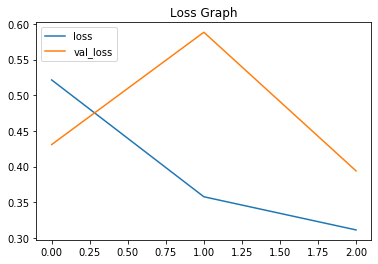

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
examples = 5
noise = np.random.normal(0, 1, (examples, random_dim))
gen_imgs = generator.predict(noise)
# Rescale images 0 - 1
gen_imgs = 0.5 * gen_imgs + 0.5
gen_imgs = gen_imgs.reshape(examples, 28, 28)
plt.figure(figsize = (14, 14))
for i in range(0, examples):
    plt.subplot(1, examples, i + 1)
    plt.imshow(gen_imgs[i], cmap='gray')